# Generative Adversarial Networks (GANs)

So far in CS231N, all the applications of neural networks that we have explored have been **discriminative models** that take an input and are trained to produce a labeled output. This has ranged from straightforward classification of image categories to sentence generation (which was still phrased as a classification problem, our labels were in vocabulary space and we’d learned a recurrence to capture multi-word labels). In this notebook, we will expand our repetoire, and build **generative models** using neural networks. Specifically, we will learn how to build models which generate novel images that resemble a set of training images.

### What is a GAN?

In 2014, [Goodfellow et al.](https://arxiv.org/abs/1406.2661) presented a method for training generative models called Generative Adversarial Networks (GANs for short). In a GAN, we build two different neural networks. Our first network is a traditional classification network, called the **discriminator**. We will train the discriminator to take images, and classify them as being real (belonging to the training set) or fake (not present in the training set). Our other network, called the **generator**, will take random noise as input and transform it using a neural network to produce images. The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can think of this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:
$$\underset{G}{\text{minimize}}\; \underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$
where $x \sim p_\text{data}$ are samples from the input data, $z \sim p(z)$ are the random noise samples, $G(z)$ are the generated images using the neural network generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real. In [Goodfellow et al.](https://arxiv.org/abs/1406.2661), they analyze this minimax game and show how it relates to minimizing the Jensen-Shannon divergence between the training data distribution and the generated samples from $G$.

To optimize this minimax game, we will aternate between taking gradient *descent* steps on the objective for $G$, and gradient *ascent* steps on the objective for $D$:
1. update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 
2. update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

While these updates are useful for analysis, they do not perform well in practice. Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**. This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident. This is the standard update used in most GAN papers, and was used in the original paper from [Goodfellow et al.](https://arxiv.org/abs/1406.2661). 

In this assignment, we will alternate the following updates:
1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:
$$\underset{G}{\text{maximize}}\;  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$
2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:
$$\underset{D}{\text{maximize}}\; \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

### What else is there?
Since 2014, GANs have exploded into a huge research area, with massive [workshops](https://sites.google.com/site/nips2016adversarial/), and [hundreds of new papers](https://github.com/hindupuravinash/the-gan-zoo). Compared to other approaches for generative models, they often produce the highest quality samples but are some of the most difficult and finicky models to train (see [this github repo](https://github.com/soumith/ganhacks) that contains a set of 17 hacks that are useful for getting models working). Improving the stabiilty and robustness of GAN training is an open research question, with new papers coming out every day! For a more recent tutorial on GANs, see [here](https://arxiv.org/abs/1701.00160). There is also some even more recent exciting work that changes the objective function to Wasserstein distance and yields much more stable results across model architectures: [WGAN](https://arxiv.org/abs/1701.07875), [WGAN-GP](https://arxiv.org/abs/1704.00028).


GANs are not the only way to train a generative model! For other approaches to generative modeling check out the [deep generative model chapter](http://www.deeplearningbook.org/contents/generative_models.html) of the Deep Learning [book](http://www.deeplearningbook.org). Another popular way of training neural networks as generative models is Variational Autoencoders (co-discovered [here](https://arxiv.org/abs/1312.6114) and [here](https://arxiv.org/abs/1401.4082)). Variational autoencoders combine neural networks with variational inference to train deep generative models. These models tend to be far more stable and easier to train but currently don't produce samples that are as pretty as GANs.

Example pictures of what you should expect (yours might look slightly different):

![caption](gan_outputs_tf.png)


## Setup

In [0]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session



## Dataset
 GANs are notoriously finicky with hyperparameters, and also require many training epochs. In order to make this assignment approachable without a GPU, we will be working on the MNIST dataset, which is 60,000 training and 10,000 test images. Each picture contains a centered image of white digit on black background (0 through 9). This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy. 

To simplify our code here, we will use the TensorFlow MNIST wrapper, which downloads and loads the MNIST dataset. See the [documentation](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/learn/python/learn/datasets/mnist.py) for more information about the interface. The default parameters will take 5,000 of the training examples and place them into a validation dataset. The data will be saved into a folder called `MNIST_data`. 

**Heads-up**: The TensorFlow MNIST wrapper returns images as vectors. That is, they're size (batch, 784). If you want to treat them as images, we have to resize them to (batch,28,28) or (batch,28,28,1). They are also type np.float32 and bounded [0,1]. 

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting .\mnist/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting .\mnist/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting .\mnist/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting .\mnist/t10k-labels-idx1-ubyte.gz


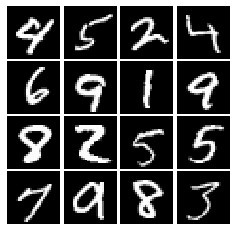

In [3]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('.\\mnist', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

## LeakyReLU
In the cell below, you should implement a LeakyReLU. See the [class notes](http://cs231n.github.io/neural-networks-1/) (where alpha is small number) or equation (3) in [this paper](http://ai.stanford.edu/~amaas/papers/relu_hybrid_icml2013_final.pdf). LeakyReLUs keep ReLU units from dying and are often used in GAN methods (as are maxout units, however those increase model size and therefore are not used in this notebook).

HINT: You should be able to use `tf.maximum`

In [0]:
def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    # TODO: implement leaky ReLU
    return tf.maximum(x, alpha*x)
def test_leaky_relu(x, y_true):
    tf.reset_default_graph()
    with get_session() as sess:
        y_tf = leaky_relu(tf.constant(x))
        y = sess.run(y_tf)
        print('Maximum error: %g'%rel_error(y_true, y))
        
def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform(shape=(batch_size,dim),minval=-1,maxval=1)     
def test_sample_noise():
    batch_size = 3
    dim = 4
    tf.reset_default_graph()
    with get_session() as sess:
        z = sample_noise(batch_size, dim)
        # Check z has the correct shape
        assert z.get_shape().as_list() == [batch_size, dim]
        # Make sure z is a Tensor and not a numpy array
        assert isinstance(z, tf.Tensor)
        # Check that we get different noise for different evaluations
        z1 = sess.run(z)
        z2 = sess.run(z)
        assert not np.array_equal(z1, z2)
        # Check that we get the correct range
        assert np.all(z1 >= -1.0) and np.all(z1 <= 1.0)
        print("All tests passed!")
        
def discriminator(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=x, units=256 , activation= lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc1')
        fc2 = tf.layers.dense(inputs=fc1, units=256 , activation=lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc2')
        fc3 = tf.layers.dense(inputs=fc2, units=1, activation=None  ,name='fc3')
        logits = fc3
        return logits
      
def test_discriminator(true_count=267009,flag=None):
    tf.reset_default_graph()
    with get_session() as sess:

        if flag =='DCGAN':
            y = discriminator_DCGAN(tf.ones((2, 784)))
        elif flag=='WGAN':
            y = discriminator_WGAN(tf.ones((2, 784)))
        else:
            y = discriminator(tf.ones((2, 784)))
        
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in discriminator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in discriminator.')
def generator(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(inputs=z, units=1024 , activation= tf.nn.relu ,name='fc1')
        fc2 = tf.layers.dense(inputs=fc1, units=1024 , activation= tf.nn.relu ,name='fc2')
        fc3 = tf.layers.dense(inputs=fc1, units=784 , activation= tf.nn.tanh ,name='fc3')
        img = fc3
        return img
            
def test_generator(true_count=1858320,flag=None):
    tf.reset_default_graph()
    with get_session() as sess:

        if flag == 'DCGAN':
            y = generator_DCGAN(tf.ones((1, 4)))
        else:
            y = generator(tf.ones((1, 4)))
        cur_count = count_params()
        if cur_count != true_count:
            print('Incorrect number of parameters in generator. {0} instead of {1}. Check your achitecture.'.format(cur_count,true_count))
        else:
            print('Correct number of parameters in generator.')            
            
def gan_loss(logits_real, logits_fake):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_real,labels=tf.ones_like(logits_real)))
    D_loss += tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.zeros_like(logits_real)))
    G_loss = tf.reduce_mean( tf.nn.sigmoid_cross_entropy_with_logits(logits=logits_fake,labels=tf.ones_like(logits_fake)))
    return D_loss, G_loss
  
def test_gan_loss(logits_real, logits_fake, d_loss_true, g_loss_true):
    tf.reset_default_graph()
    with get_session() as sess:
        d_loss, g_loss = sess.run(gan_loss(tf.constant(logits_real), tf.constant(logits_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))  

# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=1e-3, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1)
    return D_solver, G_solver  
  
  

## Putting it all together
Now just a bit of Lego Construction.. Read this section over carefully to understand how we'll be composing the generator and discriminator

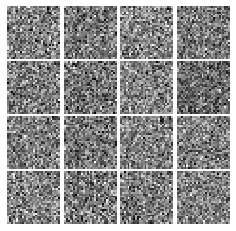


Iter: 0/4296, D: 1.959, G:0.7722
Iter: 50/4296, D: 0.1188, G:4.051
Iter: 100/4296, D: 1.312, G:0.1328
Iter: 150/4296, D: 0.3827, G:2.971
Iter: 200/4296, D: 0.699, G:0.6837


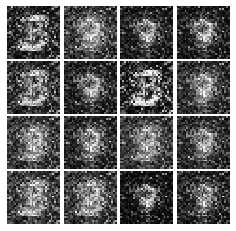


Iter: 250/4296, D: 1.027, G:0.2866
Iter: 300/4296, D: 0.7884, G:2.898
Iter: 350/4296, D: 0.6188, G:1.758
Iter: 400/4296, D: 0.9752, G:1.26
Iter: 450/4296, D: 1.481, G:0.9376


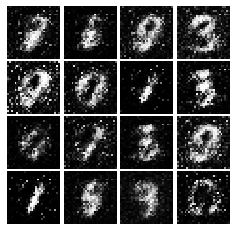


Iter: 500/4296, D: 0.8627, G:1.173
Iter: 550/4296, D: 0.7506, G:1.533
Iter: 600/4296, D: 0.9722, G:1.117
Iter: 650/4296, D: 0.6871, G:3.056
Iter: 700/4296, D: 1.182, G:1.537


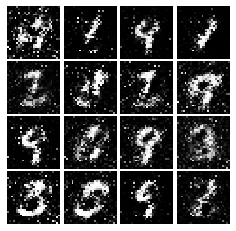


Iter: 750/4296, D: 0.9414, G:1.205
Iter: 800/4296, D: 0.943, G:1.577
Iter: 850/4296, D: 1.093, G:1.183
Iter: 900/4296, D: 1.221, G:1.997
Iter: 950/4296, D: 1.035, G:1.404


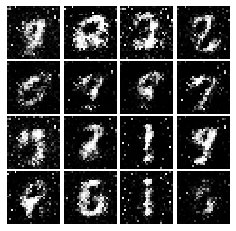


Iter: 1000/4296, D: 1.061, G:1.313
Iter: 1050/4296, D: 1.13, G:1.162
Iter: 1100/4296, D: 1.091, G:1.028
Iter: 1150/4296, D: 1.11, G:1.304
Iter: 1200/4296, D: 1.125, G:1.02


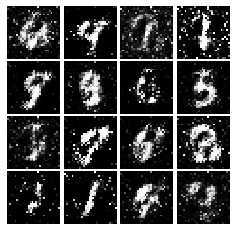


Iter: 1250/4296, D: 1.067, G:1.058
Iter: 1300/4296, D: 1.095, G:1.018
Iter: 1350/4296, D: 1.083, G:0.9942
Iter: 1400/4296, D: 1.067, G:1.335
Iter: 1450/4296, D: 1.143, G:1.102


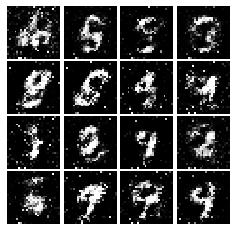


Iter: 1500/4296, D: 1.07, G:1.211
Iter: 1550/4296, D: 1.082, G:1.121
Iter: 1600/4296, D: 1.056, G:1.091
Iter: 1650/4296, D: 1.171, G:0.9805
Iter: 1700/4296, D: 1.032, G:1.216


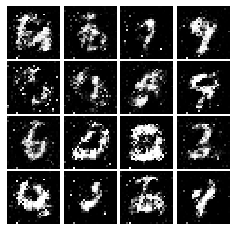


Iter: 1750/4296, D: 1.204, G:0.8814
Iter: 1800/4296, D: 1.038, G:1.103
Iter: 1850/4296, D: 1.005, G:1.107
Iter: 1900/4296, D: 1.12, G:1.288
Iter: 1950/4296, D: 1.091, G:1.237


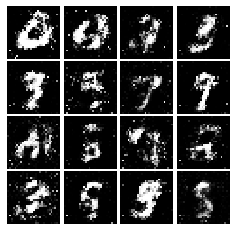


Iter: 2000/4296, D: 1.031, G:1.137
Iter: 2050/4296, D: 1.059, G:1.053
Iter: 2100/4296, D: 1.022, G:1.281
Iter: 2150/4296, D: 1.014, G:1.255
Iter: 2200/4296, D: 1.176, G:1.612


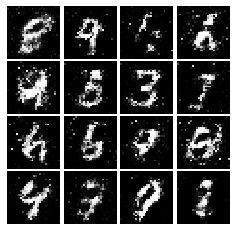


Iter: 2250/4296, D: 1.072, G:1.097
Iter: 2300/4296, D: 1.157, G:1.495
Iter: 2350/4296, D: 1.013, G:1.353
Iter: 2400/4296, D: 1.0, G:1.256
Iter: 2450/4296, D: 1.009, G:1.319


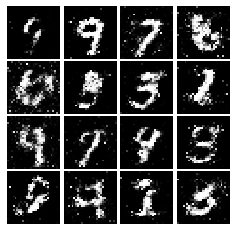


Iter: 2500/4296, D: 1.009, G:1.337
Iter: 2550/4296, D: 1.171, G:1.144
Iter: 2600/4296, D: 1.14, G:1.032
Iter: 2650/4296, D: 1.077, G:1.508
Iter: 2700/4296, D: 0.9983, G:1.202


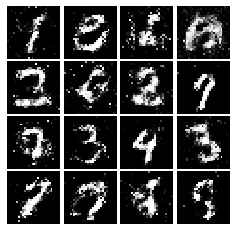


Iter: 2750/4296, D: 1.097, G:1.374
Iter: 2800/4296, D: 1.089, G:1.252
Iter: 2850/4296, D: 0.9788, G:1.203
Iter: 2900/4296, D: 1.005, G:1.176
Iter: 2950/4296, D: 1.077, G:1.469


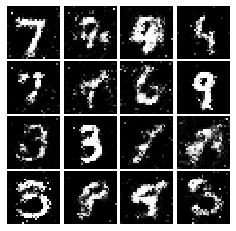


Iter: 3000/4296, D: 1.059, G:1.231
Iter: 3050/4296, D: 0.9941, G:1.525
Iter: 3100/4296, D: 0.9407, G:1.299
Iter: 3150/4296, D: 1.014, G:1.214
Iter: 3200/4296, D: 1.103, G:1.61


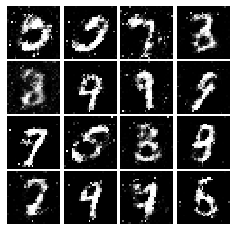


Iter: 3250/4296, D: 1.032, G:1.307
Iter: 3300/4296, D: 1.109, G:1.331
Iter: 3350/4296, D: 1.077, G:1.271
Iter: 3400/4296, D: 0.958, G:1.094
Iter: 3450/4296, D: 1.029, G:1.211


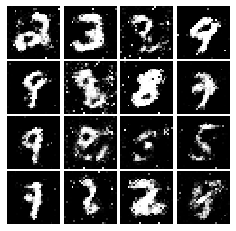


Iter: 3500/4296, D: 0.9661, G:1.315
Iter: 3550/4296, D: 0.9634, G:1.36
Iter: 3600/4296, D: 0.9659, G:1.287
Iter: 3650/4296, D: 0.9609, G:1.354
Iter: 3700/4296, D: 0.9862, G:1.249


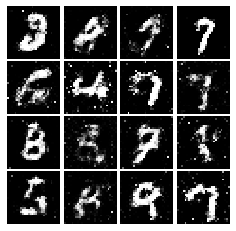


Iter: 3750/4296, D: 1.036, G:1.321
Iter: 3800/4296, D: 1.106, G:1.219
Iter: 3850/4296, D: 0.8786, G:1.214
Iter: 3900/4296, D: 0.8677, G:1.624
Iter: 3950/4296, D: 1.05, G:1.575


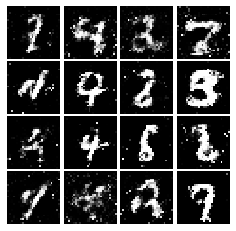


Iter: 4000/4296, D: 1.006, G:1.388
Iter: 4050/4296, D: 0.9083, G:1.367
Iter: 4100/4296, D: 0.9988, G:0.9915
Iter: 4150/4296, D: 0.8921, G:1.293
Iter: 4200/4296, D: 0.8235, G:1.476


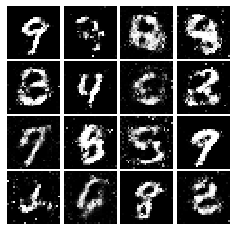


Iter: 4250/4296, D: 1.04, G:1.552
Final images


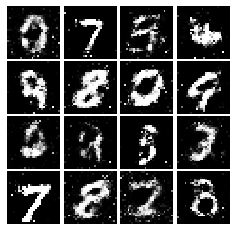

In [9]:
#@title
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 
# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss = gan_loss(logits_real, logits_fake)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

# a giant helper function
def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step)

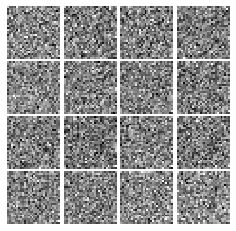


Iter: 0/4296, D: 1.81, G:0.4552
Iter: 50/4296, D: 0.1419, G:1.823
Iter: 100/4296, D: 0.1192, G:0.1588
Iter: 150/4296, D: 0.08488, G:0.4092
Iter: 200/4296, D: 0.06896, G:0.3601


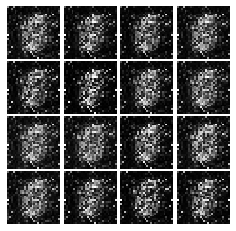


Iter: 250/4296, D: 0.3202, G:0.6003
Iter: 300/4296, D: 0.2146, G:0.7296
Iter: 350/4296, D: 0.1405, G:0.3916
Iter: 400/4296, D: 0.1261, G:0.3241
Iter: 450/4296, D: 0.1322, G:0.2392


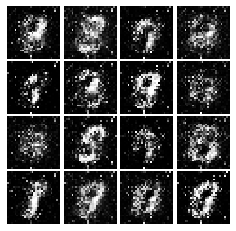


Iter: 500/4296, D: 0.1676, G:0.2348
Iter: 550/4296, D: 0.1642, G:0.3128
Iter: 600/4296, D: 0.1476, G:0.3536
Iter: 650/4296, D: 0.1296, G:0.4588
Iter: 700/4296, D: 0.1546, G:0.2345


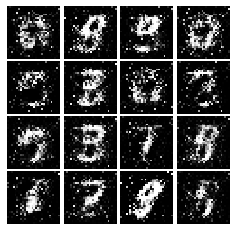


Iter: 750/4296, D: 0.1688, G:0.3819
Iter: 800/4296, D: 0.1202, G:0.2518
Iter: 850/4296, D: 0.1537, G:0.1327
Iter: 900/4296, D: 0.1414, G:0.2597
Iter: 950/4296, D: 0.1499, G:0.2489


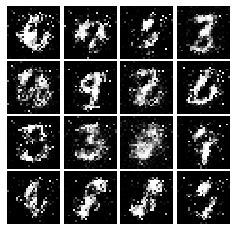


Iter: 1000/4296, D: 0.163, G:0.1861
Iter: 1050/4296, D: 0.1641, G:0.1383
Iter: 1100/4296, D: 0.2599, G:0.2776
Iter: 1150/4296, D: 0.1686, G:0.2067
Iter: 1200/4296, D: 0.1975, G:0.2478


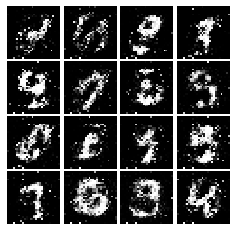


Iter: 1250/4296, D: 0.1544, G:0.245
Iter: 1300/4296, D: 0.1208, G:0.357
Iter: 1350/4296, D: 0.1424, G:0.2841
Iter: 1400/4296, D: 0.1457, G:0.2746
Iter: 1450/4296, D: 0.1611, G:0.3075


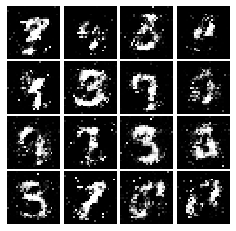


Iter: 1500/4296, D: 0.1809, G:0.1996
Iter: 1550/4296, D: 0.1521, G:0.208
Iter: 1600/4296, D: 0.1804, G:0.2181
Iter: 1650/4296, D: 0.1676, G:0.2587
Iter: 1700/4296, D: 0.1671, G:0.2466


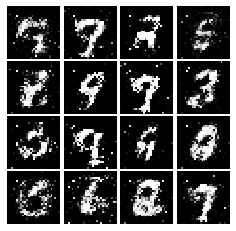


Iter: 1750/4296, D: 0.1707, G:0.292
Iter: 1800/4296, D: 0.1559, G:0.2523
Iter: 1850/4296, D: 0.1392, G:0.2546
Iter: 1900/4296, D: 0.1542, G:0.2994
Iter: 1950/4296, D: 0.1639, G:0.3509


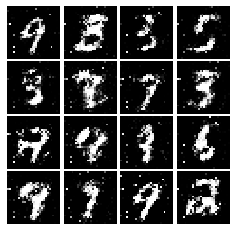


Iter: 2000/4296, D: 0.1452, G:0.2368
Iter: 2050/4296, D: 0.1696, G:0.2273
Iter: 2100/4296, D: 0.1759, G:0.2493
Iter: 2150/4296, D: 0.1612, G:0.2748
Iter: 2200/4296, D: 0.1613, G:0.2482


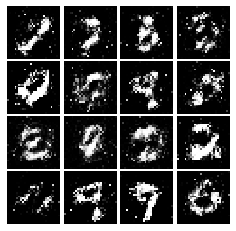


Iter: 2250/4296, D: 0.1546, G:0.2459
Iter: 2300/4296, D: 0.1632, G:0.2489
Iter: 2350/4296, D: 0.1506, G:0.2783
Iter: 2400/4296, D: 0.1733, G:0.2574
Iter: 2450/4296, D: 0.1761, G:0.2411


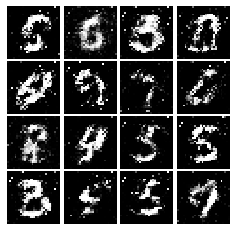


Iter: 2500/4296, D: 0.1383, G:0.224
Iter: 2550/4296, D: 0.1502, G:0.2873
Iter: 2600/4296, D: 0.156, G:0.2486
Iter: 2650/4296, D: 0.1523, G:0.2408
Iter: 2700/4296, D: 0.1936, G:0.2523


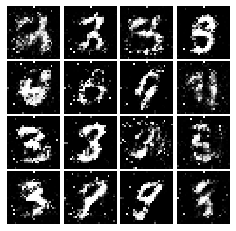


Iter: 2750/4296, D: 0.1848, G:0.2458
Iter: 2800/4296, D: 0.158, G:0.268
Iter: 2850/4296, D: 0.1457, G:0.2825
Iter: 2900/4296, D: 0.1665, G:0.2338
Iter: 2950/4296, D: 0.1594, G:0.2121


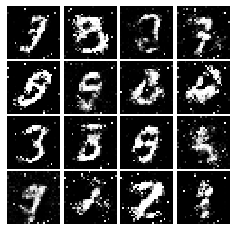


Iter: 3000/4296, D: 0.1584, G:0.2726
Iter: 3050/4296, D: 0.1632, G:0.3149
Iter: 3100/4296, D: 0.1848, G:0.2623
Iter: 3150/4296, D: 0.1672, G:0.2912
Iter: 3200/4296, D: 0.1482, G:0.2277


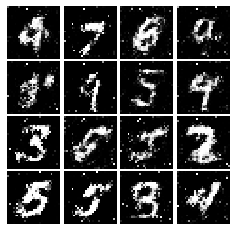


Iter: 3250/4296, D: 0.1522, G:0.2439
Iter: 3300/4296, D: 0.1676, G:0.2441
Iter: 3350/4296, D: 0.1624, G:0.2482
Iter: 3400/4296, D: 0.1586, G:0.235
Iter: 3450/4296, D: 0.1556, G:0.2752


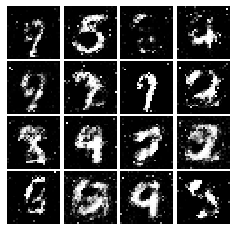


Iter: 3500/4296, D: 0.1481, G:0.2637
Iter: 3550/4296, D: 0.1605, G:0.229
Iter: 3600/4296, D: 0.1569, G:0.3221
Iter: 3650/4296, D: 0.1627, G:0.2634
Iter: 3700/4296, D: 0.1595, G:0.25


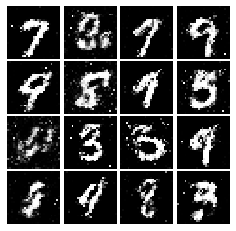


Iter: 3750/4296, D: 0.141, G:0.2391
Iter: 3800/4296, D: 0.1542, G:0.2403
Iter: 3850/4296, D: 0.1773, G:0.2502
Iter: 3900/4296, D: 0.1819, G:0.2122
Iter: 3950/4296, D: 0.1625, G:0.2078


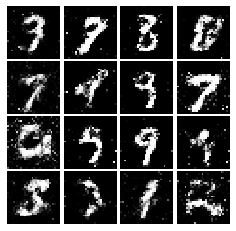


Iter: 4000/4296, D: 0.142, G:0.2352
Iter: 4050/4296, D: 0.1538, G:0.2627
Iter: 4100/4296, D: 0.137, G:0.2754
Iter: 4150/4296, D: 0.1764, G:0.2449
Iter: 4200/4296, D: 0.1678, G:0.2218


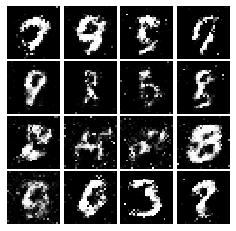


Iter: 4250/4296, D: 0.1534, G:0.2311
Final images


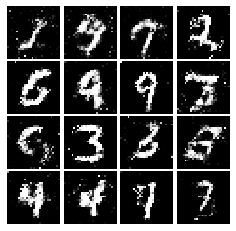

In [10]:
#####           LSGAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


def lsgan_loss(score_real, score_fake):
    """Compute the Least Squares GAN loss.
    
    Inputs:
    - score_real: Tensor, shape [batch_size, 1], output of discriminator
        score for each real image
    - score_fake: Tensor, shape[batch_size, 1], output of discriminator
        score for each fake image    
          
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = tf.reduce_mean( 0.5*tf.square( score_real -1.0 ) + 0.5*tf.square( score_fake )  )
    G_loss = tf.reduce_mean( 0.5*tf.square(score_fake - 1.0))
    return D_loss, G_loss
  
  
def test_lsgan_loss(score_real, score_fake, d_loss_true, g_loss_true):
    with get_session() as sess:
        d_loss, g_loss = sess.run(
            lsgan_loss(tf.constant(score_real), tf.constant(score_fake)))
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))
    
    
D_loss, G_loss = lsgan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step)
  

We have to recreate our network since we've changed our functions.

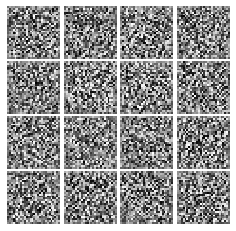


Iter: 0/4296, D: 1.352, G:0.5856
Iter: 50/4296, D: 0.49, G:2.062
Iter: 100/4296, D: 0.9946, G:0.912
Iter: 150/4296, D: 0.8264, G:1.233
Iter: 200/4296, D: 1.117, G:0.9983


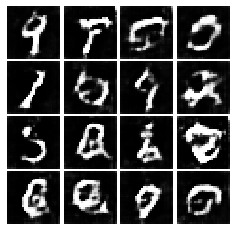


Iter: 250/4296, D: 1.237, G:1.589
Iter: 300/4296, D: 1.115, G:0.8022
Iter: 350/4296, D: 1.131, G:0.5577
Iter: 400/4296, D: 1.155, G:1.072
Iter: 450/4296, D: 1.135, G:0.9832


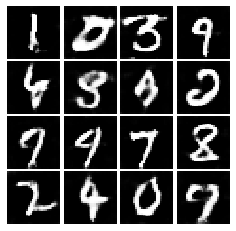


Iter: 500/4296, D: 1.194, G:1.017
Iter: 550/4296, D: 1.124, G:0.9023
Iter: 600/4296, D: 1.125, G:0.9244
Iter: 650/4296, D: 1.109, G:0.8629
Iter: 700/4296, D: 1.286, G:0.9524


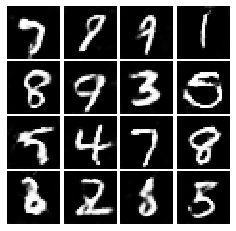


Iter: 750/4296, D: 1.247, G:1.802
Iter: 800/4296, D: 1.199, G:1.132
Iter: 850/4296, D: 1.17, G:1.065
Iter: 900/4296, D: 1.128, G:0.8035
Iter: 950/4296, D: 1.59, G:1.147


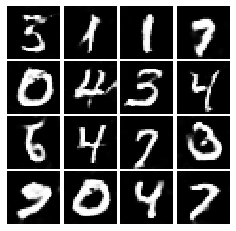


Iter: 1000/4296, D: 1.246, G:0.6696
Iter: 1050/4296, D: 1.163, G:0.7534
Iter: 1100/4296, D: 1.214, G:1.062
Iter: 1150/4296, D: 1.231, G:0.9341
Iter: 1200/4296, D: 1.183, G:0.6158


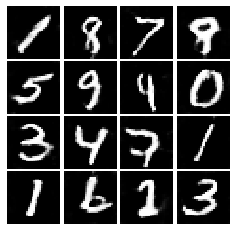


Iter: 1250/4296, D: 1.177, G:0.8807
Iter: 1300/4296, D: 1.306, G:1.64
Iter: 1350/4296, D: 1.118, G:0.7063
Iter: 1400/4296, D: 1.126, G:1.109
Iter: 1450/4296, D: 1.09, G:0.9554


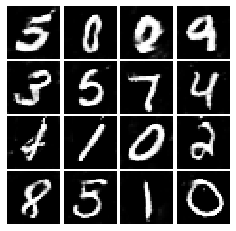


Iter: 1500/4296, D: 1.078, G:1.288
Iter: 1550/4296, D: 1.118, G:0.9326
Iter: 1600/4296, D: 1.179, G:1.336
Iter: 1650/4296, D: 1.273, G:0.7963
Iter: 1700/4296, D: 1.16, G:0.8008


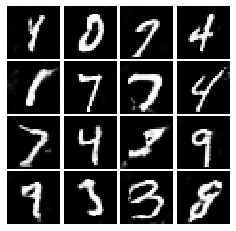


Iter: 1750/4296, D: 1.108, G:0.952
Iter: 1800/4296, D: 1.111, G:0.9294
Iter: 1850/4296, D: 1.129, G:1.141
Iter: 1900/4296, D: 1.138, G:1.592
Iter: 1950/4296, D: 1.246, G:0.9481


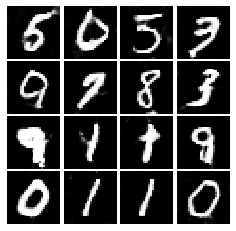


Iter: 2000/4296, D: 1.076, G:0.7994
Iter: 2050/4296, D: 1.035, G:1.075
Iter: 2100/4296, D: 1.129, G:1.167
Iter: 2150/4296, D: 1.035, G:0.9299
Iter: 2200/4296, D: 1.002, G:1.251


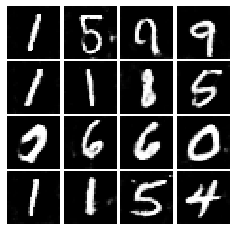


Iter: 2250/4296, D: 1.011, G:1.814
Iter: 2300/4296, D: 1.1, G:1.6
Iter: 2350/4296, D: 1.055, G:1.273
Iter: 2400/4296, D: 1.096, G:1.082
Iter: 2450/4296, D: 1.136, G:1.333


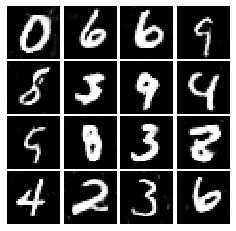


Iter: 2500/4296, D: 1.04, G:1.689
Iter: 2550/4296, D: 0.9751, G:1.017
Iter: 2600/4296, D: 1.032, G:1.093
Iter: 2650/4296, D: 1.023, G:0.7008
Iter: 2700/4296, D: 1.132, G:0.8891


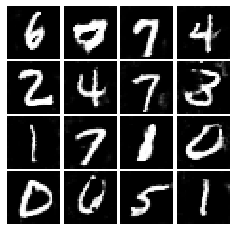


Iter: 2750/4296, D: 0.9956, G:0.7971
Iter: 2800/4296, D: 0.976, G:0.9505
Iter: 2850/4296, D: 1.024, G:1.027
Iter: 2900/4296, D: 0.9986, G:1.2
Iter: 2950/4296, D: 0.9529, G:1.744


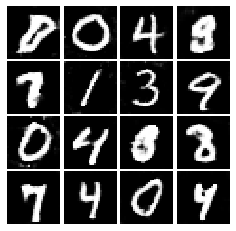


Iter: 3000/4296, D: 0.9088, G:1.171
Iter: 3050/4296, D: 1.125, G:0.7908
Iter: 3100/4296, D: 1.014, G:1.474
Iter: 3150/4296, D: 1.116, G:0.5511
Iter: 3200/4296, D: 1.11, G:1.15


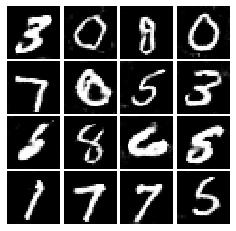


Iter: 3250/4296, D: 0.9229, G:1.589
Iter: 3300/4296, D: 1.001, G:1.618
Iter: 3350/4296, D: 0.9258, G:1.536
Iter: 3400/4296, D: 0.9368, G:1.376
Iter: 3450/4296, D: 0.8978, G:1.67


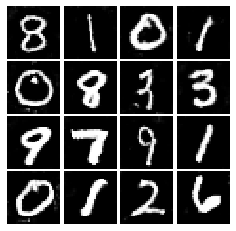


Iter: 3500/4296, D: 0.9012, G:0.9595
Iter: 3550/4296, D: 1.0, G:1.106
Iter: 3600/4296, D: 0.9996, G:0.3811
Iter: 3650/4296, D: 0.948, G:1.369
Iter: 3700/4296, D: 1.126, G:0.9896


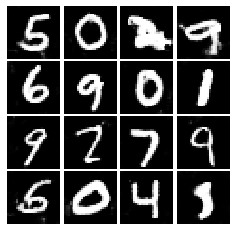


Iter: 3750/4296, D: 0.884, G:1.207
Iter: 3800/4296, D: 0.8762, G:1.411
Iter: 3850/4296, D: 0.8692, G:1.473
Iter: 3900/4296, D: 1.003, G:0.9813
Iter: 3950/4296, D: 1.2, G:2.727


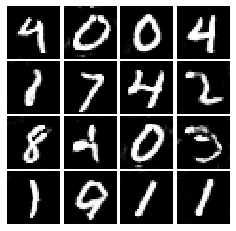


Iter: 4000/4296, D: 0.8001, G:1.262
Iter: 4050/4296, D: 0.8095, G:1.47
Iter: 4100/4296, D: 1.048, G:1.257
Iter: 4150/4296, D: 0.9076, G:1.69
Iter: 4200/4296, D: 0.7808, G:1.596


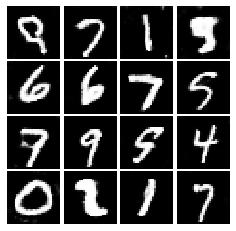


Iter: 4250/4296, D: 0.9206, G:1.366
Final images


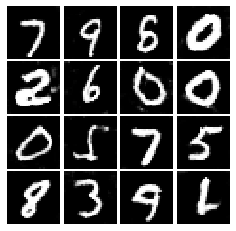

In [11]:
#####   DCGAN

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()


def discriminator_DCGAN(x):
    """Compute discriminator score for a batch of input images.
    
    Inputs:
    - x: TensorFlow Tensor of flattened input images, shape [batch_size, 784]
    
    Returns:
    TensorFlow Tensor with shape [batch_size, 1], containing the score 
    for an image being real for each input image.
    """
    with tf.variable_scope("discriminator"):
        # TODO: implement architecture
        x = tf.reshape(x,[-1,28,28,1])
        conv1_1 = tf.layers.conv2d(x, filters=32, padding='VALID', kernel_size=5, strides=1,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01), name = 'conv1_1')
        pool1_2 = tf.layers.max_pooling2d(conv1_1, pool_size=2, strides=2, padding='SAME', name='pool1_2')
        conv2_1 = tf.layers.conv2d(pool1_2, filters=64, padding='VALID', kernel_size=5, strides=1,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01), name = 'conv2_1')
        pool2_2 = tf.layers.max_pooling2d(conv2_1, pool_size=2, strides=2, padding='SAME', name='pool2_2') 
          
        flatten = tf.contrib.layers.flatten(pool2_2)
        fc3 = tf.layers.dense(flatten, units=4*4*64 , activation= lambda x: tf.nn.leaky_relu(x,0.01) ,name='fc3')
        fc4 = tf.layers.dense(fc3, units=1 , activation= None ,name='fc4')
        logits = fc4
        return logits

def generator_DCGAN(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, units=1024 , activation=tf.nn.relu ,name='fc1')
        bn2 =  tf.layers.batch_normalization(fc1, training=True,name='bn2')
        fc3 = tf.layers.dense(bn2, units=7*7*128 , activation=tf.nn.relu ,name='fc3')
        bn4 =  tf.layers.batch_normalization(fc3, training=True,name='bn4')
        to_img =  tf.reshape(bn4,[-1,7,7,128])
        deconv5 = tf.layers.conv2d_transpose(to_img,padding='SAME',filters=64,kernel_size=4, strides=2,
                                             activation=tf.nn.relu,name='deconv5')
        bn6 =  tf.layers.batch_normalization(deconv5, training=True,name='bn6')
        deconv7 = tf.layers.conv2d_transpose(bn6,padding='SAME',filters=1,kernel_size=4, strides=2,
                                             activation=tf.nn.tanh,name='deconv7')        
        img = deconv7
        return img      
    
    
    
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = generator_DCGAN(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator_DCGAN(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator_DCGAN(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator') 

D_solver,G_solver = get_solvers()
D_loss, G_loss = gan_loss(logits_real, logits_fake)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')

with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,num_epoch=10)

------

# Extra Credit 
** Be sure you don't destroy your results above, but feel free to copy+paste code to get results below **
* For a small amount of extra credit, you can implement additional new GAN loss functions below, provided they converge. See AFI, BiGAN, Softmax GAN, Conditional GAN, InfoGAN, etc. They should converge to get credit.
* Likewise for an improved architecture or using a convolutional GAN (or even implement a VAE)
* For a bigger chunk of extra credit, load the CIFAR10 data (see last assignment) and train a compelling generative model on CIFAR-10
* Demonstrate the value of GANs in building semi-supervised models. In a semi-supervised example, only some fraction of the input data has labels; we can supervise this in MNIST by only training on a few dozen or hundred labeled examples. This was first described in [Improved Techniques for Training GANs](https://arxiv.org/abs/1606.03498).
* Something new/cool.

#### Describe what you did here

# WGAN-GP (Small Extra Credit)

Please only attempt after you have completed everything above.

We'll now look at [Improved Wasserstein GAN](https://arxiv.org/abs/1704.00028) as a newer, more stable alernative to the original GAN loss function. For this part, all we have to do is change the loss function and retrain the model. We'll implement Algorithm 1 in the paper. 

You'll also need to use a discriminator and corresponding generator without max-pooling. So we cannot use the one we currently have from DCGAN. Pair the DCGAN Generator (from InfoGAN) with the discriminator from [InfoGAN](https://arxiv.org/pdf/1606.03657.pdf) Appendix C.1 MNIST (We don't use Q, simply implement the network up to D). You're also welcome to define a new generator and discriminator in this notebook, in case you want to use the fully-connected pair of D(x) and G(z) you used at the top of this notebook.

Architecture:
* 64 Filters of 4x4, stride 2, LeakyReLU
* 128 Filters of 4x4, stride 2, LeakyReLU
* BatchNorm
* Flatten
* Fully connected 1024, LeakyReLU
* Fully connected size 1

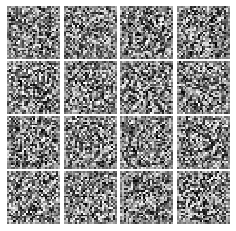


Iter: 0/2148, D: -108.6, G:-5.607
Iter: 20/2148, D: -891.0, G:-422.4
Iter: 40/2148, D: -245.7, G:-824.0
Iter: 60/2148, D: -269.7, G:-790.1
Iter: 80/2148, D: -112.7, G:-817.0
Iter: 100/2148, D: -122.1, G:-754.5
Iter: 120/2148, D: -105.1, G:-492.3
Iter: 140/2148, D: 234.7, G:-217.2
Iter: 160/2148, D: 12.99, G:-201.0
Iter: 180/2148, D: 0.8746, G:-193.9
Iter: 200/2148, D: -2.835, G:-184.0
Iter: 220/2148, D: 1.2, G:-147.8
Iter: 240/2148, D: -4.95, G:-138.8


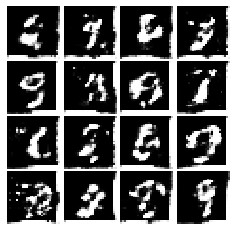


Iter: 260/2148, D: -7.764, G:-133.9
Iter: 280/2148, D: -10.05, G:-133.6
Iter: 300/2148, D: -19.08, G:-150.9
Iter: 320/2148, D: -85.4, G:-304.6
Iter: 340/2148, D: -83.15, G:-363.2
Iter: 360/2148, D: -71.67, G:-206.3
Iter: 380/2148, D: -71.6, G:-335.1
Iter: 400/2148, D: -85.64, G:-349.1
Iter: 420/2148, D: -85.32, G:-274.4
Iter: 440/2148, D: -118.3, G:-359.7
Iter: 460/2148, D: -91.91, G:-322.1
Iter: 480/2148, D: -92.2, G:-261.4


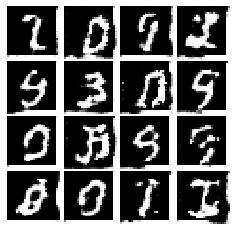


Iter: 500/2148, D: -20.05, G:-105.9
Iter: 520/2148, D: -19.5, G:-100.3
Iter: 540/2148, D: -67.13, G:-235.7
Iter: 560/2148, D: -80.42, G:-232.3
Iter: 580/2148, D: -130.3, G:-327.7
Iter: 600/2148, D: -112.5, G:-310.6
Iter: 620/2148, D: -102.5, G:-230.7
Iter: 640/2148, D: -80.24, G:-236.5
Iter: 660/2148, D: -101.4, G:-259.5
Iter: 680/2148, D: -21.55, G:-139.6
Iter: 700/2148, D: -70.36, G:-241.5
Iter: 720/2148, D: -97.38, G:-251.4
Iter: 740/2148, D: -11.77, G:-202.4


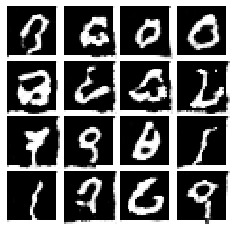


Iter: 760/2148, D: -91.6, G:-243.3
Iter: 780/2148, D: -93.25, G:-233.3
Iter: 800/2148, D: -101.3, G:-243.9
Iter: 820/2148, D: -129.7, G:-332.7
Iter: 840/2148, D: -64.53, G:-168.6
Iter: 860/2148, D: -86.59, G:-194.6
Iter: 880/2148, D: -90.23, G:-232.6
Iter: 900/2148, D: -40.1, G:-182.2
Iter: 920/2148, D: -86.99, G:-177.2
Iter: 940/2148, D: -113.2, G:-277.2
Iter: 960/2148, D: -85.3, G:-190.7
Iter: 980/2148, D: -94.21, G:-237.3


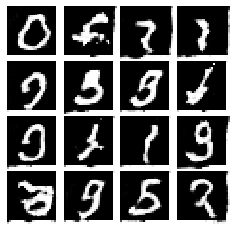


Iter: 1000/2148, D: -108.6, G:-134.1
Iter: 1020/2148, D: -104.7, G:-148.0
Iter: 1040/2148, D: -74.14, G:-150.2
Iter: 1060/2148, D: -77.27, G:-204.1
Iter: 1080/2148, D: -74.75, G:-184.6
Iter: 1100/2148, D: -89.02, G:-204.3
Iter: 1120/2148, D: -2.597, G:-98.54
Iter: 1140/2148, D: -12.74, G:-110.3
Iter: 1160/2148, D: -72.23, G:-156.1
Iter: 1180/2148, D: -100.7, G:-77.88
Iter: 1200/2148, D: -55.42, G:-156.1
Iter: 1220/2148, D: -91.8, G:-215.7
Iter: 1240/2148, D: -89.98, G:-157.0


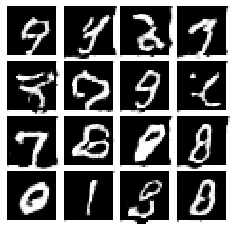


Iter: 1260/2148, D: -5.149, G:-97.24
Iter: 1280/2148, D: -5.005, G:-90.43
Iter: 1300/2148, D: -6.882, G:-90.0
Iter: 1320/2148, D: -6.459, G:-84.05
Iter: 1340/2148, D: -8.468, G:-82.28
Iter: 1360/2148, D: -9.407, G:-79.06
Iter: 1380/2148, D: -13.92, G:-75.15
Iter: 1400/2148, D: -15.45, G:-70.65
Iter: 1420/2148, D: -20.45, G:-64.6
Iter: 1440/2148, D: -29.89, G:-90.23
Iter: 1460/2148, D: -83.87, G:-121.5
Iter: 1480/2148, D: -23.93, G:-44.1


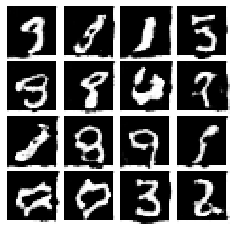


Iter: 1500/2148, D: -13.64, G:-82.48
Iter: 1520/2148, D: -31.1, G:-95.48
Iter: 1540/2148, D: -70.26, G:-93.72
Iter: 1560/2148, D: -90.41, G:-170.9
Iter: 1580/2148, D: -67.67, G:-106.0
Iter: 1600/2148, D: -82.42, G:-137.0
Iter: 1620/2148, D: -108.5, G:-102.5
Iter: 1640/2148, D: -106.8, G:-226.1
Iter: 1660/2148, D: -4.751, G:-77.07
Iter: 1680/2148, D: -36.27, G:-167.4
Iter: 1700/2148, D: 8.331, G:-118.5
Iter: 1720/2148, D: -97.39, G:-184.6
Iter: 1740/2148, D: -17.81, G:-41.44


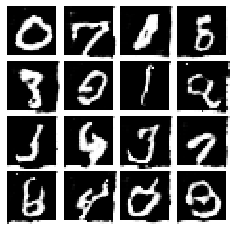


Iter: 1760/2148, D: -74.39, G:-161.0
Iter: 1780/2148, D: -86.99, G:-92.27
Iter: 1800/2148, D: -100.4, G:-87.15
Iter: 1820/2148, D: -5.129, G:-78.85
Iter: 1840/2148, D: -8.445, G:-73.31
Iter: 1860/2148, D: -15.21, G:-93.34
Iter: 1880/2148, D: -99.03, G:-153.1
Iter: 1900/2148, D: -117.8, G:-186.7
Iter: 1920/2148, D: -132.5, G:-106.8
Iter: 1940/2148, D: -4.548, G:-67.19
Iter: 1960/2148, D: -6.769, G:-68.35
Iter: 1980/2148, D: -9.252, G:-78.33


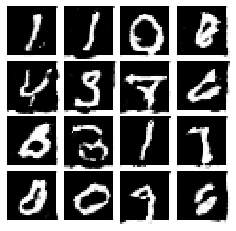


Iter: 2000/2148, D: -119.8, G:-172.7
Iter: 2020/2148, D: -13.33, G:-90.22
Iter: 2040/2148, D: -66.37, G:-139.9
Iter: 2060/2148, D: -82.37, G:-114.6
Iter: 2080/2148, D: -94.53, G:-240.1
Iter: 2100/2148, D: -76.95, G:-222.0
Iter: 2120/2148, D: -111.5, G:-94.5
Iter: 2140/2148, D: -114.8, G:-133.3
Final images


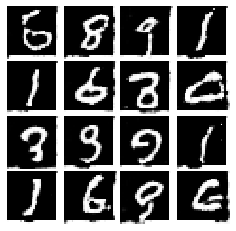

In [19]:
##################   WGAN

def discriminator_WGAN(x):
    with tf.variable_scope('discriminator'):
        # TODO: implement architecture
        init = tf.contrib.layers.xavier_initializer()
        x = tf.reshape(x,[-1,28,28,1])
        conv1 = tf.layers.conv2d(x, filters=64, padding='VALID', kernel_size=4, strides=2,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01),kernel_initializer=init, name = 'conv1')
        conv2 = tf.layers.conv2d(conv1, filters=128, padding='VALID', kernel_size=4, strides=2,
                                   activation=lambda x: tf.nn.leaky_relu(x,0.01),kernel_initializer=init, name = 'conv2')
        bn3 = tf.layers.batch_normalization(conv2, training=True,name='bn3')
        
        flatten = tf.contrib.layers.flatten(bn3)
        
        fc4 = tf.layers.dense(flatten, units=1024 , activation=lambda x: tf.nn.leaky_relu(x,0.01) ,kernel_initializer=init,name='fc4')
        fc5 = tf.layers.dense(fc4, units=1 , activation= None ,kernel_initializer=init,name='fc5')
        logits = fc5
        return logits

def generator_DCGAN(z):
    """Generate images from a random noise vector.
    
    Inputs:
    - z: TensorFlow Tensor of random noise with shape [batch_size, noise_dim]
    
    Returns:
    TensorFlow Tensor of generated images, with shape [batch_size, 784].
    """
    with tf.variable_scope("generator"):
        # TODO: implement architecture
        fc1 = tf.layers.dense(z, units=1024 , activation=tf.nn.relu ,name='fc1')
        bn2 =  tf.layers.batch_normalization(fc1, training=True,name='bn2')
        fc3 = tf.layers.dense(bn2, units=7*7*128 , activation=tf.nn.relu ,name='fc3')
        bn4 =  tf.layers.batch_normalization(fc3, training=True,name='bn4')
        to_img =  tf.reshape(bn4,[-1,7,7,128])
        deconv5 = tf.layers.conv2d_transpose(to_img,padding='SAME',filters=64,kernel_size=4, strides=2,
                                             activation=tf.nn.relu,name='deconv5')
        bn6 =  tf.layers.batch_normalization(deconv5, training=True,name='bn6')
        deconv7 = tf.layers.conv2d_transpose(bn6,padding='SAME',filters=1,kernel_size=4, strides=2,
                                             activation=tf.nn.tanh,name='deconv7')        
        img = deconv7
        return img 

      
def wgangp_loss(logits_real, logits_fake, batch_size, x, G_sample):
    """Compute the WGAN-GP loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - batch_size: The number of examples in this batch
    - x: the input (real) images for this batch
    - G_sample: the generated (fake) images for this batch
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    """
    # TODO: compute D_loss and G_loss
    D_loss = - tf.reduce_mean(logits_real) + tf.reduce_mean(logits_fake)
    G_loss = - tf.reduce_mean(logits_fake)

    # lambda from the paper
    lam = 10
    
    # random sample of batch_size (tf.random_uniform)
    eps = tf.random_uniform([batch_size,1], minval=0.0, maxval=1.0)
    x_hat = eps*x+(1-eps)*G_sample

    # Gradients of Gradients is kind of tricky!
    with tf.variable_scope('',reuse=True) as scope:
        grad_D_x_hat = tf.gradients(discriminator_WGAN(x_hat), x_hat)

    grad_norm = tf.norm(grad_D_x_hat[0], axis=1, ord='euclidean')
    grad_pen = tf.reduce_mean(tf.square(grad_norm-1))

    D_loss += lam*grad_pen

    return D_loss, G_loss
      
# a giant helper function
def run_a_wgan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              show_every=250, print_every=20, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample)
            fig = show_images(samples[:16])
            plt.show()
            print()
        # run a batch of data through the network
        
        if it < 25 or it % 500 == 0:
            citers = 100
        else:
            citers = 5
        for j in range(citers):
            minibatch,minbatch_y = mnist.train.next_batch(batch_size)
            _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict={x: minibatch})
            
        minibatch,minbatch_y = mnist.train.next_batch(batch_size)
        _, G_loss_curr = sess.run([G_train_step, G_loss])

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}/{}, D: {:.4}, G:{:.4}'.format(it,max_iter,D_loss_curr,G_loss_curr))
    print('Final images')
    samples = sess.run(G_sample)

    fig = show_images(samples[:16])
    plt.show()      
      
      
tf.reset_default_graph()

batch_size = 128
# our noise dimension
noise_dim = 96

# placeholders for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
z = sample_noise(batch_size, noise_dim)
# generated images
G_sample = tf.reshape(generator_DCGAN(z),[batch_size,-1])

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    logits_real = discriminator_WGAN(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    logits_fake = discriminator_WGAN(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,'generator')

D_solver, G_solver = get_solvers()

D_loss, G_loss = wgangp_loss(logits_real, logits_fake, 128, x, G_sample)
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS,'generator')


with get_session() as sess:
    sess.run(tf.global_variables_initializer())
    run_a_wgan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,batch_size=128,num_epoch=5)

